**Name:** Drasti Parikh

**Student Id:** 101419828

# Lab Week 12 - Transfer Learning: Using a pretrained model

## Tranfer learning

Usually we use a combination of a convolutional network that extracts abstract features from the image and a fully connected part (often called "top") that uses those features for classification.

![](https://www.mcpressonline.com/images/thumbnails/thumb_20230621SandersFig2.JPG)


## ImageNet
ImageNet is a large dataset of over 14 million labeled images organized according to the WordNet hierarchy. It's a crucial resource for training and evaluating computer vision models, particularly deep learning models. By providing a standardized dataset with high-quality annotations, ImageNet has significantly accelerated progress in image classification, object detection, and other vision tasks.

https://en.wikipedia.org/wiki/ImageNet

![](https://blog.roboflow.com/content/images/size/w1000/2021/06/image-18.png)

## VGG Net
[VGG16](https://en.wikipedia.org/wiki/VGGNet), published in 2014, achieved top ranks in a competition for classifying ImageNet images into 1000 categories.

Architecture of VGG16:

![](https://media.geeksforgeeks.org/wp-content/uploads/20200219152207/new41.jpg)

## Reusing pre-trained networks
Trainig a fairly large network like VGG16 on the 14 million images from ImageNet takes considerable time and resources but results in a CNN that can reliably recognize a large set of features in any image. It is very useful to utilize this pre-trained network for feature detection in any images that might resemble those from ImageNet and then train a new fully connected network to classify the images using these features.


![](https://dev-to-uploads.s3.amazonaws.com/i/2oyycxxs02jmcghplwc4.png)




## Setp 1: Loading the data - same as last week

We will be using the same cats and dogs dataset from the last week, but downloded in simpler way.

In [1]:
## Download a zip with a subset of the cats and dogs from Gootl Drive
!gdown 1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS

Downloading...
From (original): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS
From (redirected): https://drive.google.com/uc?id=1HxDoufgbF11R_xPfFmdXLnfztPXYaKiS&confirm=t&uuid=5f1d41f0-8dca-4e30-b720-1aec2ed53925
To: /content/catsVdogs_small.zip
100% 114M/114M [00:02<00:00, 45.7MB/s]


In [2]:
!unzip -o -q catsVdogs_small.zip

### Data preprocessing (For this section just run the cells)

**Copying images to training, validation, and test directories**

In [3]:
# imports and setup

import numpy as np
import matplotlib.pylab as plt

import os, shutil, pathlib

import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path('small')


**Using `image_dataset_from_directory` to read images**

In [4]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Displaying the the data and labels yielded by the `Dataset`

`train_dataset`, `validation_dataset`, and `test_dataset` behave like a **generator** in the sense that it **yields data lazily** when iterated over, instead of loading everything into memory at once.

**TODO: Iterate over `train_dataset` and take one sample batch and labels, print the shape of the batch and save it in `sample_batch` variable**

In [5]:
# Iterate over train_dataset
for images, labels in train_dataset:
    # This will give us the first batch
    sample_batch = images
    sample_labels = labels

    # Print the shape of the batch
    print("Shape of the sample batch:", sample_batch.shape)

    # We break after the first iteration to get only one batch
    break

# Now sample_batch contains one batch of images, and sample_labels contains the corresponding labels


Shape of the sample batch: (32, 180, 180, 3)


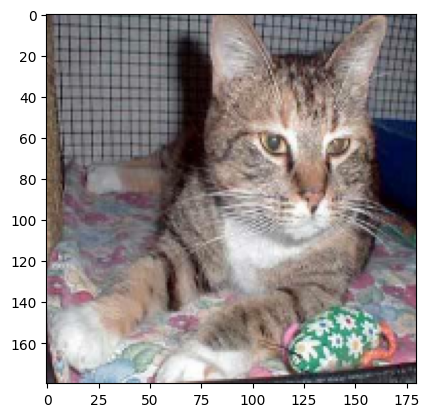

In [8]:
import matplotlib.pylab as plt
plt.imshow(sample_batch[10].numpy().astype("uint8"))

**TODO: What is the shape of your image?**

In [9]:
# Get the shape of the 11th image in the sample batch (index 10)
image_shape = sample_batch[10].numpy().shape

print("The shape of the image is:", image_shape)


The shape of the image is: (180, 180, 3)


## Step 2: Load the pretrained VGG16 model from Keras

**Instantiating the VGG16 convolutional base**

In [10]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Step 3:  Feature extraction with a pretrained model

**Extracting the VGG16 features and corresponding labels**

In [12]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

**TODO:Explore the shape and size of the extracted features**

In [13]:
# Explore feature shapes
print("Training features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

# Check feature dimensions for a single sample
print("\nFeature dimensions per image:", train_features[0].shape)

# Calculate total features per image
features_per_image = np.prod(train_features[0].shape)
print(f"Total features per image: {features_per_image} ({train_features[0].shape[0]}x{train_features[0].shape[1]}x{train_features[0].shape[2]})")

# Check memory usage
print("\nMemory usage:")
print(f"Training features: {train_features.nbytes / (1024**2):.2f} MB")
print(f"Validation features: {val_features.nbytes / (1024**2):.2f} MB")
print(f"Test features: {test_features.nbytes / (1024**2):.2f} MB")


Training features shape: (2000, 5, 5, 512)
Validation features shape: (1000, 5, 5, 512)
Test features shape: (2000, 5, 5, 512)

Feature dimensions per image: (5, 5, 512)
Total features per image: 12800 (5x5x512)

Memory usage:
Training features: 97.66 MB
Validation features: 48.83 MB
Test features: 97.66 MB


## Step 4- Pipeline A:
## Definine and train the densely connected classifier that uses the extracted features as input

**TODO: Define and compile the model to classify pictures as cats vs dogs**
- What will be the size of the output layer?
- What activation function should the output layer use?
- What loss function should be used?
- Layers to use
  - `Input` layer and pass the shape of the features e.g. `shape=(5, 5, 512)`
  - `Flatten` as the first layer to reshape the feature maps returned by the CSS into 1-D arrays
  - `Dense` layer with 128 neurons
  - `Dropout` layer with 30% to 50% dropout rate
  - `Output` layer
- Don't forget to add `accuracy` metric when compiling the model
- You can use either `Sequential` or functional API to define the model

In [19]:
from keras import models
from keras import layers

# Define the model architecture
model = models.Sequential([
    layers.Input(shape=(5, 5, 512)),  # Input layer matching VGG16 features
    layers.Flatten(),                 # Flatten to 1D array (5*5*512 = 12800 features)
    layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation
    layers.Dropout(0.5),              # 50% dropout for regularization
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



**Plotting the results**

**TODO: Plot the history of loss and accuracty as we did in the previous labs**

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8706 - loss: 3.5607 - val_accuracy: 0.9620 - val_loss: 0.5108
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9640 - loss: 0.5795 - val_accuracy: 0.9700 - val_loss: 0.3487
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9844 - loss: 0.0850 - val_accuracy: 0.9700 - val_loss: 0.3096
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9865 - loss: 0.0859 - val_accuracy: 0.9690 - val_loss: 0.2896
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9904 - loss: 0.0787 - val_accuracy: 0.9660 - val_loss: 0.3168
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9864 - loss: 0.0652 - val_accuracy: 0.9700 - val_loss: 0.2173
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9929 - loss: 0.0401 - val_accuracy: 0.9530 - val_loss: 0.6286
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9901 - loss: 0.0964 - val_accuracy: 0.9690 - val_loss

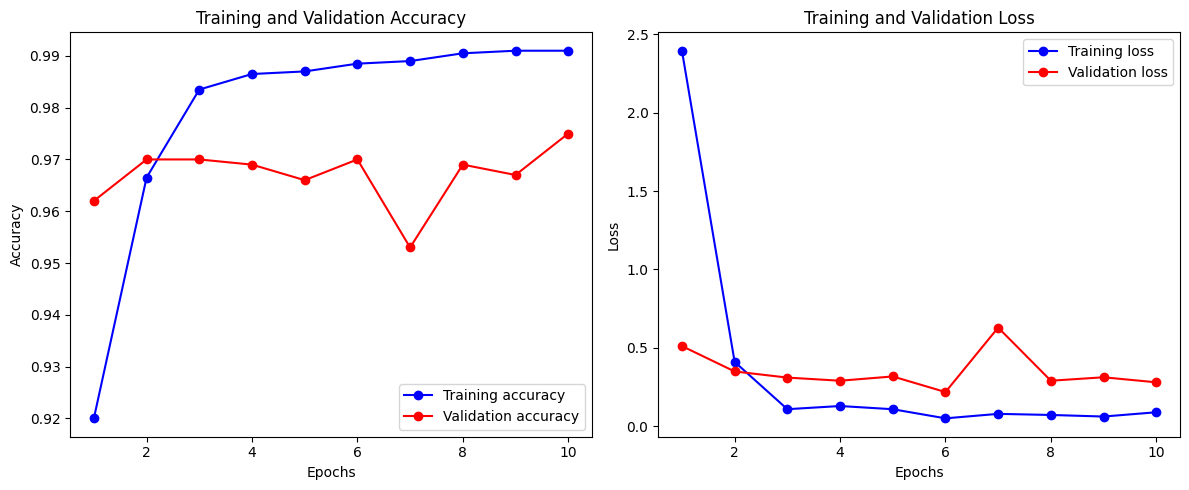

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9790 - loss: 0.1650
Test accuracy: 0.9770


In [20]:
from keras import models
from keras import layers
import matplotlib.pyplot as plt

# Define the model
model = models.Sequential([
    layers.Input(shape=(5, 5, 512)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_features, val_labels))

# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.4f}")


**Evaluate the model using test data**

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features, test_labels, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions for the test set
predictions = model.predict(test_features)

# Convert probabilities to class labels
predicted_labels = (predictions > 0.5).astype(int)

# Calculate and print additional metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels))

print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, predicted_labels))


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9790 - loss: 0.1650
Test Loss: 0.2206
Test Accuracy: 0.9770
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1000
           1       0.97      0.98      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix:
[[973  27]
 [ 19 981]]


## Step 4- Pipeline B:
## Feature extraction together with classifier in a single architecture

**Instantiating and freezing the VGG16 convolutional base**

In [22]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False) ## this means we only get the convolutional part without the densely connected top


conv_base.trainable = False ## This freezes the wieghts on the convolutional part

**Printing the list of trainable weights before and after freezing**

In [23]:
conv_base.trainable = True
print("This is the number of trainable weight tensors "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weight tensors before freezing the conv base: 26


**In order to calculate the number of trainable parameters we need to add up the size of each tensor. try running this with the layers fronzen and unfrozen and compare to the number returned by `conv_base.summary()`**

In [25]:
trainable_params = 0
for layer in conv_base.trainable_weights:
  trainable_params += layer.numpy().size

print(f'Number of trainable parameters is {trainable_params}')


Number of trainable parameters is 14714688


In [26]:
conv_base.trainable = False
print("This is the number of trainable weight tensors "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weight tensors after freezing the conv base: 0


**Frozen ConvNet and densely connected network in a single architecture**

In [27]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)

x = conv_base(x) # Convolutional base

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(inputs, outputs)
model2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [28]:
model2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 180, 180)       │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 180, 180)       │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 180, 180, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 180, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 5, 5, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 12800)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 256)            │      3,277,056 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │            257 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

**This model (Pipeline B) is exactly the same as what you did for Pipeline A.**

**TODO: Train `model2`, evaluate the trained model, and plot the results.**

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 350ms/step - accuracy: 0.8644 - loss: 26.7655 - val_accuracy: 0.9730 - val_loss: 4.9009
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 221ms/step - accuracy: 0.9805 - loss: 2.7751 - val_accuracy: 0.9720 - val_loss: 6.1714
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 230ms/step - accuracy: 0.9852 - loss: 2.8591 - val_accuracy: 0.9680 - val_loss: 6.6918
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.9951 - loss: 0.3367 - val_accuracy: 0.9740 - val_loss: 5.8217
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.9941 - loss: 0.6224 - val_accuracy: 0.9780 - val_loss: 4.8844
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 1.0000 - loss: 7.2395e-09 - val_accuracy: 0.9780 - val_loss: 4.8825
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.9934 - loss: 0.7970 - val_accuracy: 0.9770 - val_loss: 6.6201
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.9934 - loss: 0.5902 - val

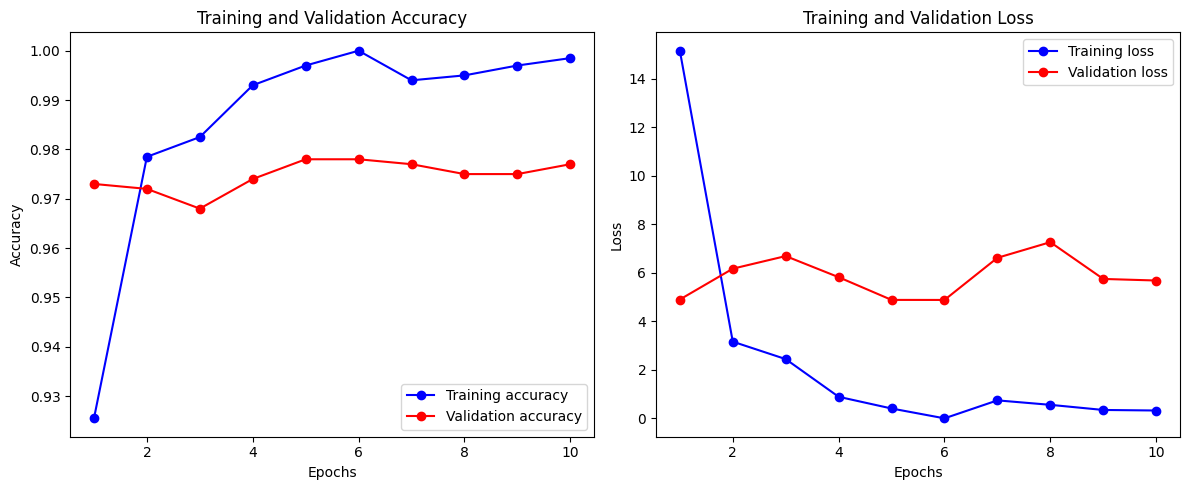

63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      1000
           1       0.50      0.49      0.50      1000

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000


Confusion Matrix:
[[512 488]
 [508 492]]


In [29]:
# Train the model
history = model2.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset
)

# Evaluate the model
test_loss, test_accuracy = model2.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Function to plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Generate predictions for the test set
predictions = model2.predict(test_dataset)

# Convert probabilities to class labels
predicted_labels = (predictions > 0.5).astype(int)

# Get true labels from the test dataset
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Calculate and print additional metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))
